<a href="https://colab.research.google.com/github/adirox3359/Quant-Task/blob/main/General_code_for_non_volatile_markets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle


In [230]:
#backtesting for last 5 day data set
import yfinance as yf
import datetime

ticker = 'PAYTM.BO'
end_date = datetime.date.today() - datetime.timedelta(days=5)


df = yf.download(ticker, end=end_date)


print(f"Data fetched from {df.index.min().date()} to {df.index.max().date()} for {ticker}")
print(df.head())
print(df.tail())


/tmp/ipython-input-230-2954181892.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data fetched from 2025-06-10 to 2025-07-09 for PAYTM.BO
Price            Close        High         Low        Open   Volume
Ticker        PAYTM.BO    PAYTM.BO    PAYTM.BO    PAYTM.BO PAYTM.BO
Date                                                               
2025-06-10  961.500000  973.400024  956.150024  970.000000   194413
2025-06-11  960.200012  977.700012  952.250000  962.200012   253553
2025-06-12  895.150024  929.950012  864.200012  929.950012   963518
2025-06-13  882.099976  896.900024  869.900024  869.950012   239700
2025-06-16  877.250000  887.650024  858.000000  882.349976   213279
Price            Close        High         Low        Open   Volume
Ticker        PAYTM.BO    PAYTM.BO    PAYTM.BO    PAYTM.BO PAYTM.BO
Date                                                               
2025-07-03  925.049988  933.099976  917.000000  926.849976   140576
2025-07-04  930.599976  934.799988  922.200012  927.900024   124990
2025-07-07  918.500000  930.849976  916.599976  929.250000  

In [231]:
'''# 2. DOWNLOAD FULL DATA FROM EARLIEST AVAILABLE TO TODAY (IPO to now)
import datetime
import yfinance as yf

ticker = 'JSWSTEEL.BO'  # Change this to any symbol (e.g., 'ADANIENT.NS', 'RELIANCE.NS', etc.)

df = yf.download(ticker)  # No start/end fetches ALL available data


print(f"Fetched data from {df.index.min().date()} to {df.index.max().date()} for {ticker}")
print(df.head())'''

'# 2. DOWNLOAD FULL DATA FROM EARLIEST AVAILABLE TO TODAY (IPO to now)\nimport datetime\nimport yfinance as yf\n\nticker = \'JSWSTEEL.BO\'  # Change this to any symbol (e.g., \'ADANIENT.NS\', \'RELIANCE.NS\', etc.)\n\ndf = yf.download(ticker)  # No start/end fetches ALL available data\n\n\nprint(f"Fetched data from {df.index.min().date()} to {df.index.max().date()} for {ticker}")\nprint(df.head())'

In [232]:
#CALCULATE RSI AND MACD

#RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df)

#MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [233]:
#EMA 20 and EMA 50 Crossover
ema_fast  = df['Close'].ewm(span=20, adjust=False).mean()
ema_slow  = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_Diff']   = ema_fast - ema_slow
df['EMA_Cross']  = df['EMA_Diff'].apply(np.sign).diff().fillna(0)







In [234]:
#VOLUME FEATURES

# Percentage change in volume compared to previous day
df['Volume_Change_Pct'] = df['Volume'].pct_change()





In [235]:
#FUTURE VOLATILITY


df['Returns'] = df['Close'].pct_change()


vol_window = 5
df['FutureVolatility'] = df['Returns'].shift(-1).rolling(window=vol_window).std()

In [236]:
# CLEAN ANY inf, -inf, or NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

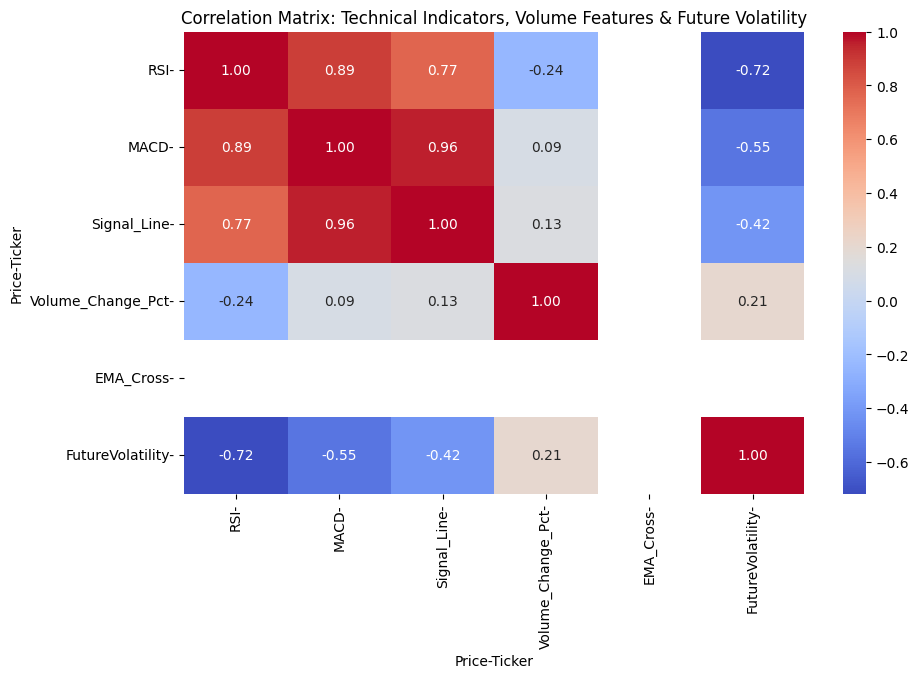

In [237]:
# Correlation Matrix

df.dropna(inplace=True)

features = ['RSI', 'MACD', 'Signal_Line', 'Volume_Change_Pct','EMA_Cross']

X = df[features]
y = df['FutureVolatility']


corr = df[features + ['FutureVolatility']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Technical Indicators, Volume Features & Future Volatility')
plt.show()


In [238]:
#Data Training and Testing Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.8f}')


Mean Squared Error: 0.00000016


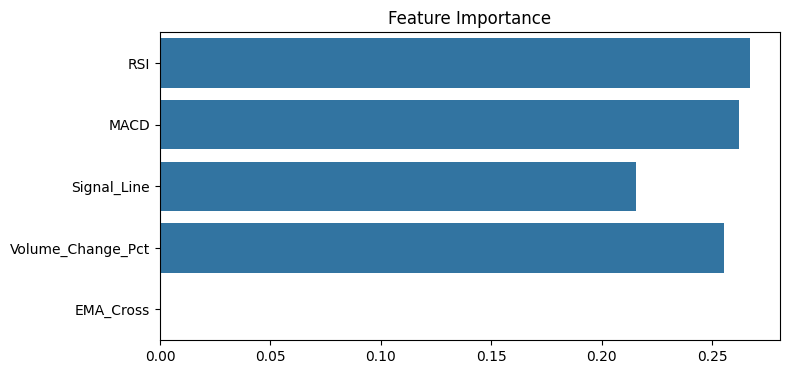

In [239]:
#Feature importance Plot

plt.figure(figsize=(8, 4))
sns.barplot(x=model.feature_importances_, y=features)
plt.title('Feature Importance')
plt.show()



In [240]:
#Pickle

with open('volatility_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved as 'volatility_model.pkl'")


✅ Model saved as 'volatility_model.pkl'


In [241]:
#Prediction

with open('volatility_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

example_input = X_test.iloc[-1:]
print("Predicted Volatility Percentage:", loaded_model.predict(example_input)[0] * 100)


Predicted Volatility Percentage: 0.6658528094160201
